In [ ]:
"""
This software is part of GPU Ocean. 

Copyright (C) 2024 SINTEF Digital

Tutorial for implementing new drift functionality.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>.
"""

# A field of drifters in a single ocean model

The goal of this tutorial  is to give a compact example of how to run a field of drifters in a single ocean model

In [25]:
# Load required modules
%matplotlib inline

from IPython.display import display

import numpy as np
import copy 

#For plotting
from matplotlib import pyplot as plt
import matplotlib as mpl
plt.rcParams["animation.html"] = "jshtml"
mpl.rcParams['figure.facecolor'] = 'white'

# Import relevant modules from within GPU Ocean
from gpuocean.SWEsimulators import GPUOceanSim
from gpuocean.utils import IPythonMagic, NetCDFInitialization, PlotHelper, DrifterPlotHelper
from gpuocean.drifters import GPUDrifterCollection, LagrangianUtils

from importlib import reload

In [2]:
# Create the GPU context
%cuda_context_handler gpu_ctx

In [3]:
# Url or path to operational ocean forecast
source_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

# Use a predefined subdomain
casename = 'north_cape'

reload(NetCDFInitialization)
T_end_hours = 23

# Load initial and boundary conditions, bathymetry, landmask, forcing, etc
sim_args = NetCDFInitialization.getInitialConditionsNorKystCases(source_url, casename, timestep_indices=list(range(T_end_hours+1)))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


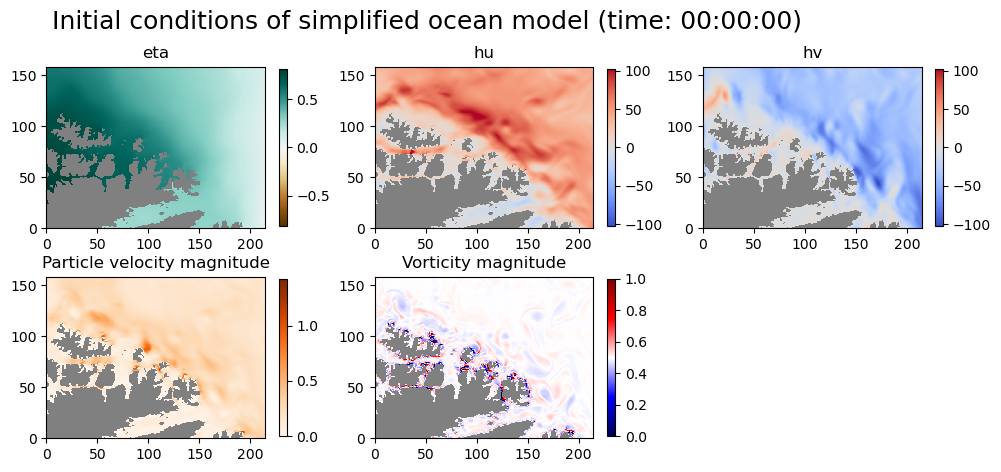

In [4]:
if 'sim' in globals():
    sim.cleanUp()

fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 2)

# Create simulation object
sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(fine_sim_args))


# Plot initial conditions of the simplified ocean model
_, _ = PlotHelper.plotSim(sim, plot_title="Initial conditions of simplified ocean model", add_extra=True)

In [5]:
# Initial positions for drifters.
# We aim to make a line (or grid?) of driftesr outside of Vesterålen

x_positions = np.arange(100, 151, 0.5)*1000
y_positions = np.arange(100, 121, 0.5)*1000

num_drifters = len(x_positions)*len(y_positions)
init_positions = np.zeros((num_drifters, 2))
d = 0
for x in x_positions:
    for y in y_positions:
        init_positions[d, 0] = x
        init_positions[d, 1] = y
        d = d+1        

In [6]:
# Create drifter object
drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                     boundaryConditions=sim.boundary_conditions,
                                                     domain_size_x=sim.nx*sim.dx,
                                                     domain_size_y=sim.ny*sim.dy)
drifters.setDrifterPositions(init_positions)

# Attach the drifters to the simulator
sim.attachDrifters(drifters)

C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\drifters\GPUDrifterCollection.py:75: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu

  defines={'block_width': self.block_width, 'block_height': self.block_height


C:\Users\havardh\playground-win\gpuocean\havahol-gpuocean\src\gpuocean\utils\DrifterPlotHelper.py:169: RuntimeWarning: invalid value encountered in sqrt
  velo = np.sqrt(u**2 + v**2)


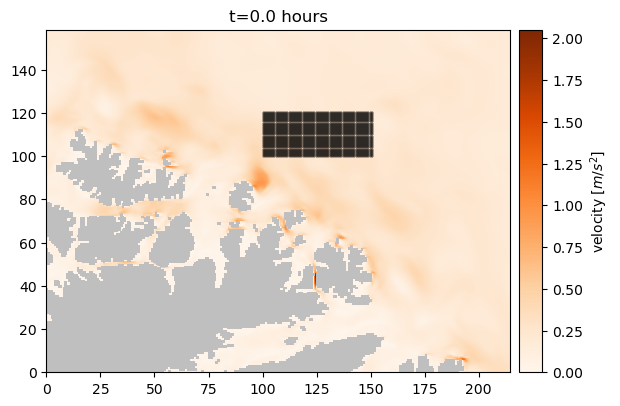

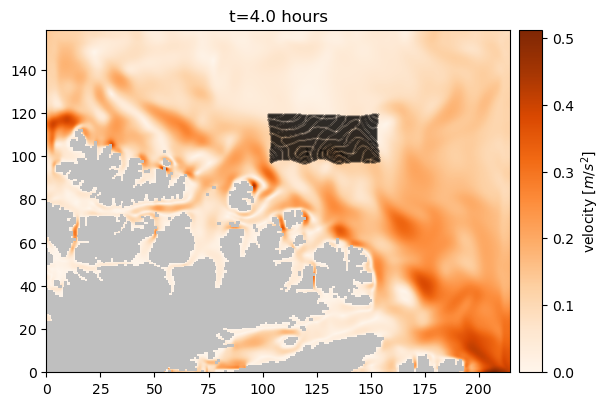

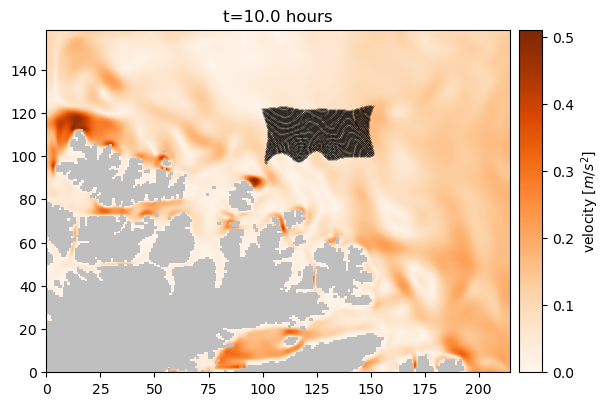

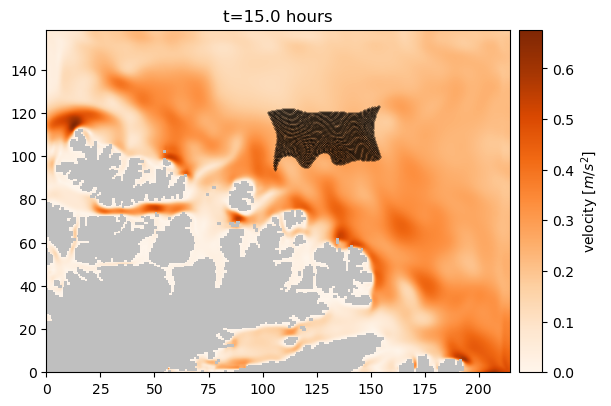

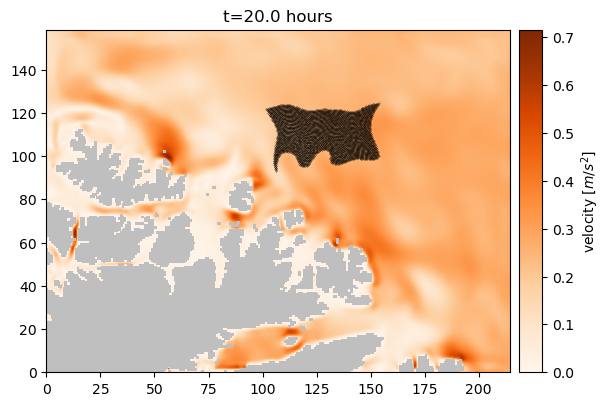

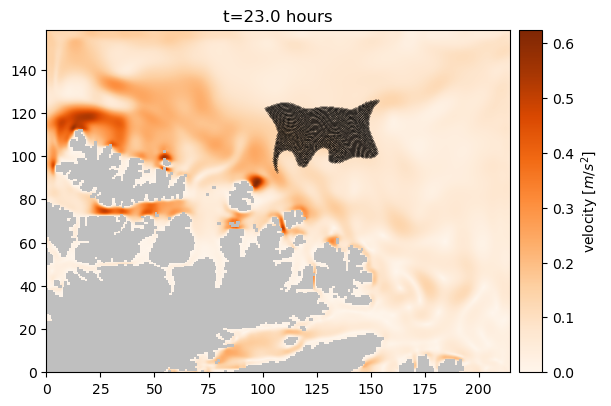

In [7]:
for i in range(T_end_hours+1):
    if i > 0:
        sim.step(3600)

    if i in [0, 4, 10, 15, 20, T_end_hours]:
        ax = DrifterPlotHelper.background_from_sim(sim)
        DrifterPlotHelper.add_drifter_positions_on_background(ax, drifters.getDrifterPositions(), s=0.05)
        ax.set_title("t="+str(sim.t/3600)+" hours")
    

Text(0.5, 1.0, 'hei')

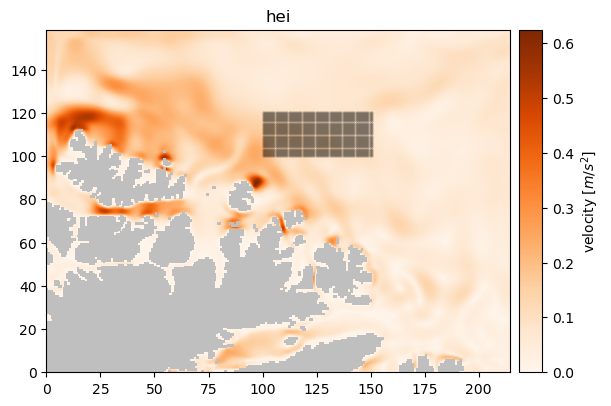

In [8]:
reload(DrifterPlotHelper)

ax = DrifterPlotHelper.background_from_sim(sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, init_positions, s=0.01)
ax.set_title("hei")


In [9]:
NetCDFInitialization.getNorkystSubdomains()
NetCDFInitialization.getCaseLocation("barents_sea")

{'name': 'barents_sea', 'x0': 2150, 'x1': 2575, 'y0': 575, 'y1': 875}

# Compare different resolutions

In [10]:
extra_fine_sim_args = NetCDFInitialization.rescaleInitialConditions(sim_args, 4)

# Create simulation object
original_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(sim_args))
extra_fine_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(extra_fine_sim_args))

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!
This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [11]:
# Create drifter object
original_drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                              boundaryConditions=original_sim.boundary_conditions,
                                                              domain_size_x=original_sim.nx*original_sim.dx,
                                                              domain_size_y=original_sim.ny*original_sim.dy)
original_drifters.setDrifterPositions(init_positions)

# Attach the drifters to the simulator
original_sim.attachDrifters(original_drifters)

In [12]:
# Create drifter object
extra_fine_drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                                boundaryConditions=extra_fine_sim.boundary_conditions,
                                                                domain_size_x=extra_fine_sim.nx*original_sim.dx,
                                                                domain_size_y=extra_fine_sim.ny*original_sim.dy)
extra_fine_drifters.setDrifterPositions(init_positions)

# Attach the drifters to the simulator
extra_fine_sim.attachDrifters(extra_fine_drifters)

In [13]:
for i in range(T_end_hours+1):
    if i > 0:
        original_sim.step(3600)

In [14]:
for i in range(T_end_hours+1):
    if i > 0:
        extra_fine_sim.step(3600)

In [15]:
print(extra_fine_sim.nx, extra_fine_sim.ny)
print(original_sim.nx, original_sim.nx)

1076 796
266 266


Text(0.5, 1.0, 'extra fine resolution')

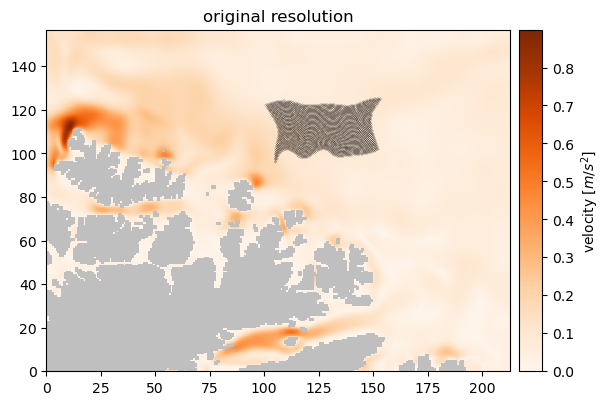

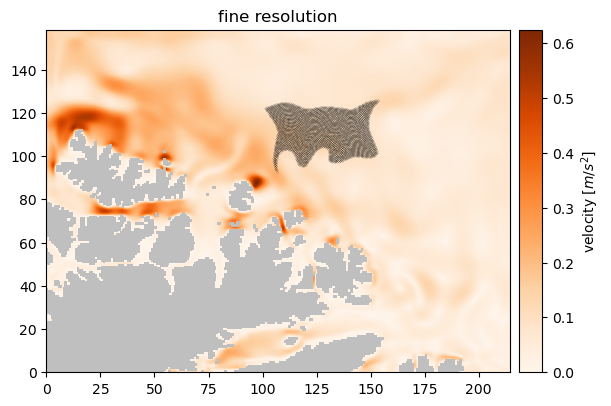

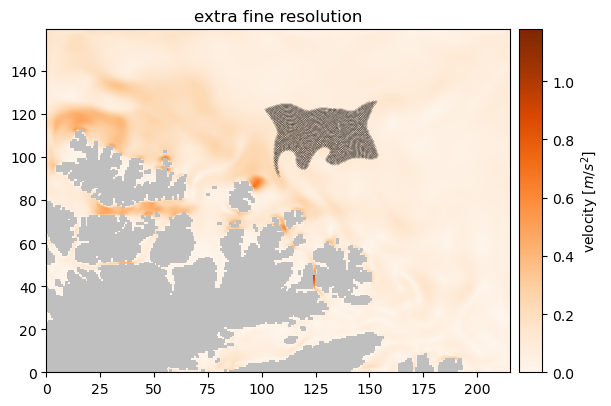

In [16]:
reload(DrifterPlotHelper)

ax = DrifterPlotHelper.background_from_sim(original_sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, original_drifters.getDrifterPositions(), s=0.01)
ax.set_title("original resolution")

ax = DrifterPlotHelper.background_from_sim(sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, drifters.getDrifterPositions(), s=0.01)
ax.set_title("fine resolution")

ax = DrifterPlotHelper.background_from_sim(extra_fine_sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, extra_fine_drifters.getDrifterPositions(), s=0.01)
ax.set_title("extra fine resolution")

Text(0.5, 1.0, 'extra fine resolution')

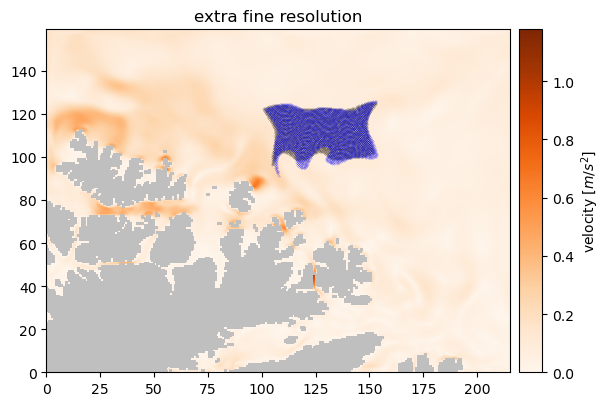

In [17]:
ax = DrifterPlotHelper.background_from_sim(extra_fine_sim)
DrifterPlotHelper.add_drifter_positions_on_background(ax, original_drifters.getDrifterPositions(), s=0.01, color='black')
DrifterPlotHelper.add_drifter_positions_on_background(ax, extra_fine_drifters.getDrifterPositions(), s=0.01, color='blue')
ax.set_title("extra fine resolution")

([<AxesSubplot:title={'center':'eta'}>,
  <AxesSubplot:title={'center':'hu'}>,
  <AxesSubplot:title={'center':'hv'}>,
  <AxesSubplot:title={'center':'Particle velocity magnitude'}>,
  <AxesSubplot:title={'center':'Vorticity magnitude'}>,
  None],
  None])

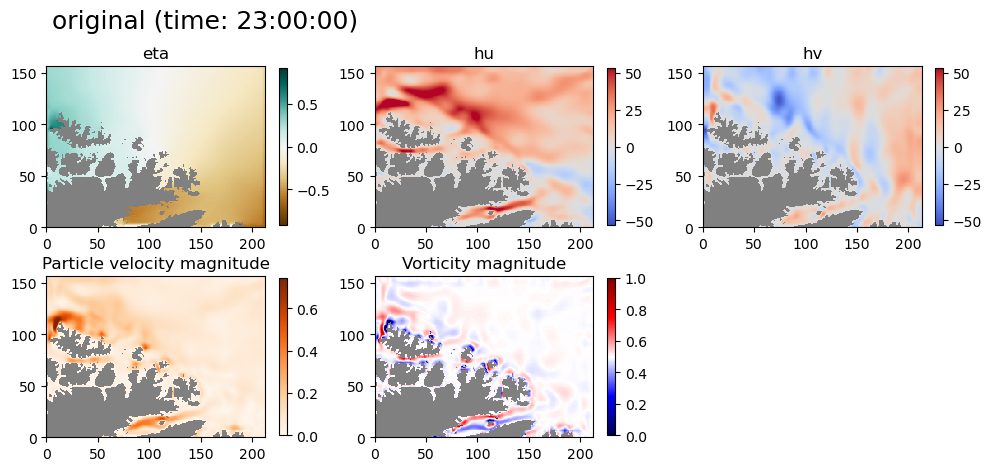

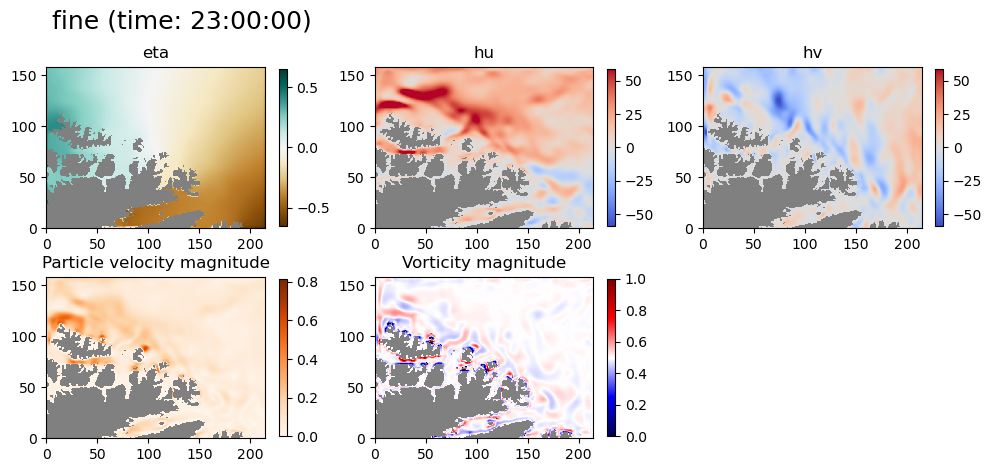

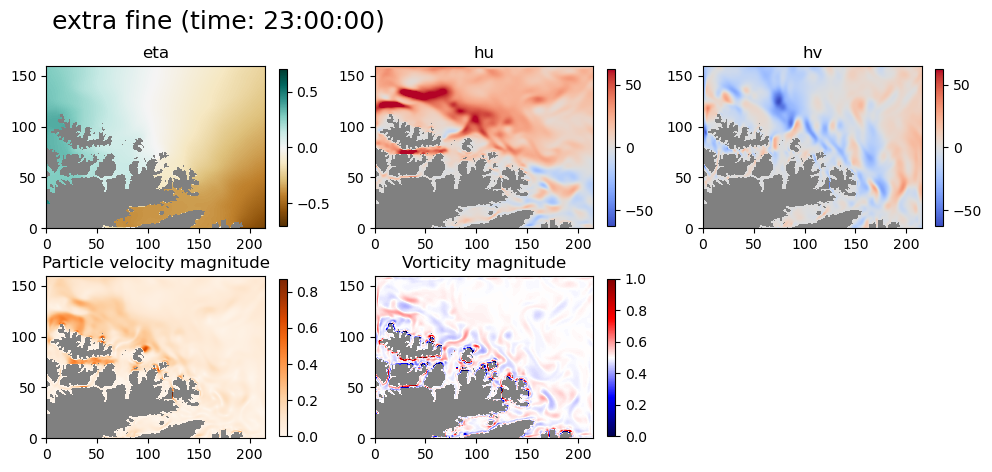

In [18]:
PlotHelper.plotSim(original_sim, add_extra=True, plot_title="original")
PlotHelper.plotSim(sim, add_extra=True, plot_title="fine")
PlotHelper.plotSim(extra_fine_sim, add_extra=True, plot_title="extra fine")


0.00023342670401493932


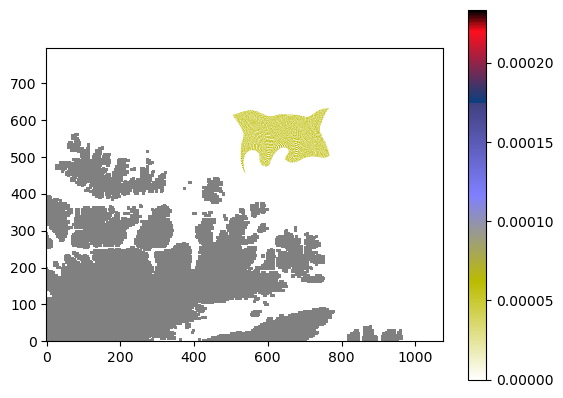

In [27]:
c = LagrangianUtils.concentrationFromSim(extra_fine_sim)
# c = LagrangianUtils.lagrangian2concentration(extra_fine_sim.drifters.getDrifterPositions(), 
#                                              original_sim.nx, original_sim.ny, original_sim.dx, original_sim.dy)

cmap = copy.copy(plt.cm.gist_stern_r)
cmap.set_bad(color='grey')
plt.imshow(c, origin='lower', cmap=cmap)
plt.colorbar()

print(np.max(c))

In [21]:
# Initial positions for drifters.
# We aim to make a line (or grid?) of driftesr outside of Vesterålen

x_positions = np.arange(100, 151, 0.0327)*1000
y_positions = np.arange(100, 121, 0.0327)*1000



num_drifters = len(x_positions)*len(y_positions)
print(num_drifters)
init_positions = np.zeros((num_drifters, 2))
d = 0
for x in x_positions:
    for y in y_positions:
        init_positions[d, 0] = x
        init_positions[d, 1] = y
        d = d+1        

1003080


In [22]:
# Create simulation object
many_drifters_sim = GPUOceanSim.GPUOceanSim(gpu_ctx, **NetCDFInitialization.removeMetadata(fine_sim_args))

# Create drifter object
reload(GPUDrifterCollection)
many_drifters = GPUDrifterCollection.GPUDrifterCollection(gpu_ctx, num_drifters,
                                                     boundaryConditions=many_drifters_sim.boundary_conditions,
                                                     domain_size_x=many_drifters_sim.nx*many_drifters_sim.dx,
                                                     domain_size_y=many_drifters_sim.ny*many_drifters_sim.dy)
many_drifters.setDrifterPositions(init_positions)


# Attach the drifters to the simulator
many_drifters_sim.attachDrifters(many_drifters)

This will give inaccurate angle along the border!
This will give inaccurate coriolis along the border!


In [23]:
for i in range(T_end_hours+1):
    if i > 0:
        many_drifters_sim.step(3600)

0.00017545958447980222


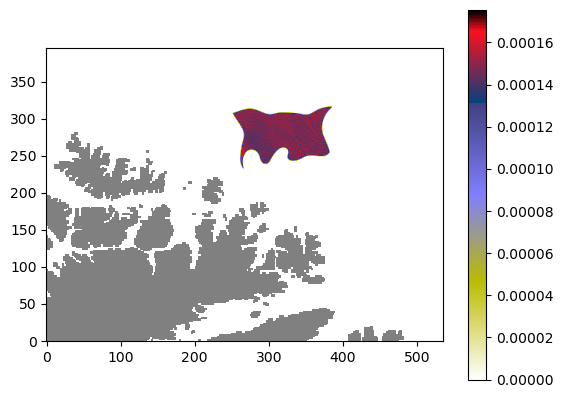

In [28]:
c = LagrangianUtils.concentrationFromSim(many_drifters_sim)

cmap = copy.copy(plt.cm.gist_stern_r)
cmap.set_bad(color='grey')
plt.imshow(c, origin='lower', cmap=cmap)
plt.colorbar()

print(np.max(c))